# PCA analysis with MDPlus

The MDPlus package includes a Prinipal Component Analysis (PCA) module. This has an interface similar to the PCA module available through [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), but adapted to the particular characteristics of MD trajectory (or ensemble) data.

Specifically:

1. The coordinate data given to the .fit() and .fit_transform() methods is expected to be a [n_frames, n_atoms, 3] array.

2. The coordinate data returned by the .inverse_transform() method will have a shape [n_frames, n_atoms, 3].

3. The coordinates are least-squares fitted to remove global translation and rotation before the PCA is done.

## General workflow
----------------
A trajectory is loaded using [mdtraj](http://mdtraj.org), [mdanalysis](http://mdanalysis.org), etc. - anything that can provide a numpy array of the coordinate data.

Here we use mdtraj:

In [1]:
import mdtraj as mdt
t = mdt.load('../test/examples/test.nc', top='../test/examples/test.pdb')

Because of its computational expense, it's normal to do the PCA analysis on a representative subset of the atoms rather than all of them: maybe just heavy atoms, maybe just C-alpha atoms of a protein. Here we use all heavy atoms:

In [2]:
heavy = t.topology.select('mass > 2.0')
t_heavy = t.atom_slice(heavy)

The PCA functions in MDPlus operate on just the numpy arrays of coordinates, so they are compatible with a wide range of Python packages that can read and write trajectory data. So we extract the relevant numpy array:

In [3]:
traj_coordinates = t_heavy.xyz

Now we can perform the PCA analysis. We create an instance of the MDPlus PCA class, and then build a model by giving our trajectory data to it via a call to its .fit() method:

In [4]:
from mdplus.pca import PCA
p = PCA()
p.fit(traj_coordinates)

The PCA object has a few attributes:

n_atoms = 454
n_components = 10


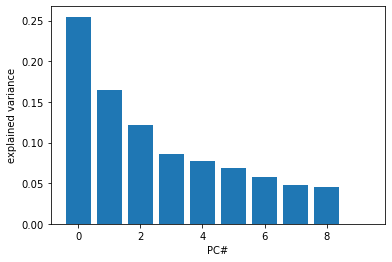

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.bar(range(p.n_components), p.eigenvalues)
plt.xlabel('PC#')
plt.ylabel('explained variance')

print('n_atoms = {}'.format(p.n_atoms))
print('n_components = {}'.format(p.n_components))

By default, the PCA method returns as many components as it can, which is the minimum of the number of frames, and 3 * the number of atoms. If you only want a few PCs, you can set this when you create the PCA instance:

In [6]:
p4 = PCA(n_components=4)
p4.fit(traj_coordinates)
print('n_components = {}'.format(p4.n_components))

n_components = 4


To transform the coordinates (or any other set of coordinates) into the PCA space, we use the PCA object's .transform() method. This returns an array of shape [n_frames, n_components], which in PCA-speak is often called the **scores** matrix. The transpose of the scores matrix is often called the **projections** matrix. Thus:

    scores[0] : the coordinates of the first frame in the trajectory in the PCA space
    scores[:, 0] : the value of the first PC for each snapshot in the trajectory.


Text(0, 0.5, 'PC2')

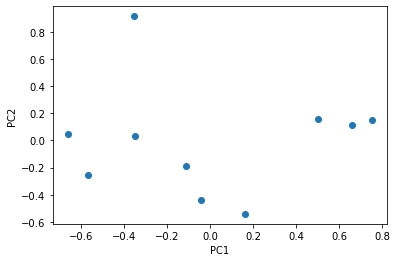

In [7]:
scores = p4.transform(traj_coordinates)
plt.plot(scores[:, 0], scores[:, 1], 'o')
plt.xlabel('PC1')
plt.ylabel('PC2')

## Extras

The pca module also provides a library interface to the latest version of the [PyPcazip](https://bitbucket.org/ramonbsc/pypcazip/src/master/) trajectory file compression method:

In [10]:
from mdplus.pca import pcazipsave, pcazipload
from mdplus.utils import rmsd
from pathlib import Path

pcazipsave(t.xyz, 'test.xdr')
t.save('test.nc')
# compare the sizes of the files:
print('xdr file size: ', Path('test.xdr').stat().st_size)
print('nc file size: ', Path('test.nc').stat().st_size)
# Check the accuracy of the compression/decompression cycle:
pxyz = pcazipload('test.xdr')
rms = 0
for original, compressed in zip(t.xyz, pxyz):
    rms += rmsd(original, compressed)
print('mean rmsd:', rms / t.n_frames)

xdr file size:  30620
nc file size:  108420
mean rmsd: 0.004763187654316425


The configuration of a trained PCA transformer can be saved to a file, and this then used to recreate the transformer at another time:

In [13]:
import json
config = p4.get_state()
with open('pca_state.json', 'w') as f:
    json.dump(config, f)

In [14]:
p4b = PCA()
with open('pca_state.json') as f:
    config = json.load(f)
p4b.set_state(config)
scores_b = p4b.transform(traj_coordinates)
print(scores - scores_b)

[[-3.5762787e-07  5.9604645e-07  2.3841858e-07  1.4901161e-07]
 [-5.0896406e-04  5.3552538e-04 -4.4377148e-04 -1.9001961e-04]
 [-1.5252829e-04 -2.7975067e-04 -9.3393028e-04 -8.0011785e-04]
 [-9.3394518e-04  4.8923492e-04  8.2665682e-04  1.2597442e-04]
 [-1.4644861e-04  3.2998621e-04  8.7253749e-05 -4.3493509e-04]
 [-9.4439834e-05 -6.3598156e-05  2.5093555e-04  2.5929511e-04]
 [-3.7053227e-04  1.2804866e-03  2.0962954e-04 -3.4206361e-04]
 [-2.3838878e-03  1.8394440e-03 -1.8022992e-03 -2.3662299e-03]
 [-4.1469932e-03  2.5789216e-03 -1.2470931e-03 -8.4277242e-04]
 [-3.4471154e-03  6.9031417e-03  3.1632185e-03 -1.9006133e-03]]
